# Graph Data Science for Logistics: Experimentation with Air Cargo Shipment Data

In [1]:
import pandas as pd
import configparser
import numpy as np
import matplotlib.pyplot as plt

In [2]:
config = configparser.RawConfigParser()
config.read('/Users/zachblumenfeld/devtools/aura-freight-demo.ini')
HOST = config['NEO4J']['HOST']
USERNAME = config['NEO4J']['USERNAME']
PASSWORD = config['NEO4J']['PASSWORD']

In [3]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(HOST, auth=(USERNAME, PASSWORD), aura_ds=True)

## Logistic Network Statistics

In [4]:
#gds.run_cypher('MATCH(a) WHERE NOT a:Airport SET a:Checkpoint RETURN count(a)')

### Shipment Statistics

In [6]:
# Number of shipments
gds.run_cypher('''
    MATCH()-[r:FREIGHT_TRANSPORT]->() RETURN count(DISTINCT r.shipmentId) AS numberOfShipments
''')

,numberOfShipments
0,3942


In [7]:
# shipments pivot by inbound leg count
gds.run_cypher('''
    MATCH()-[r:FREIGHT_TRANSPORT]->()
    WITH r.shipmentId AS shipmentId, max(r.legNumber) AS numberOfInboundLegs
    RETURN numberOfInboundLegs, count(shipmentId) AS shipmentCount
''')

,numberOfInboundLegs,shipmentCount
0,3,1366
1,2,1258
2,1,1318


### Shipment Leg Statistics

In [8]:
# Number of legs
gds.run_cypher('''
    MATCH()-[r:FREIGHT_TRANSPORT]->()
    WITH DISTINCT r.legId AS legId,
        CASE r.legNumber
            WHEN -1 THEN "OUTBOUND"
            ELSE "INBOUND"
        END AS logisticType
    RETURN logisticType, count(legId) AS numberOfLegs
''')

,logisticType,numberOfLegs
0,OUTBOUND,3942
1,INBOUND,7932


In [9]:
# leg pivot by logistic type and segment count
gds.run_cypher('''
    MATCH()-[r:FREIGHT_TRANSPORT]->()
    WITH r.legId AS legId,
    max(r.segmentNumber) AS numberOfSegments,
    CASE r.legNumber
        WHEN -1 THEN "OUTBOUND"
        ELSE "INBOUND"
    END AS logisticType
    RETURN logisticType, numberOfSegments, count(legId) AS legCount ORDER BY logisticType, numberOfSegments
''')

,logisticType,numberOfSegments,legCount
0,INBOUND,1,5555
1,INBOUND,2,2332
2,INBOUND,3,45
3,OUTBOUND,1,2097
4,OUTBOUND,2,1819
5,OUTBOUND,3,26


In [10]:
# statistics for transportation
df = gds.run_cypher('''
    MATCH(n0)-[r:FREIGHT_TRANSPORT]->(n1)
    WITH r, n0.airportId as departureAirportId, r.effectiveMinutes AS effectiveMinutes, r.plannedMinutes AS plannedMinutes, n1.airportId AS arrivalAirportId
    RETURN departureAirportId, arrivalAirportId, avg(plannedMinutes), stDev(plannedMinutes), min(plannedMinutes), max(plannedMinutes), count(*) AS cnt
    ORDER BY cnt DESC
''')
df.describe()

,departureAirportId,arrivalAirportId,avg(plannedMinutes),stDev(plannedMinutes),min(plannedMinutes),max(plannedMinutes),cnt
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,435.342739,442.607469,859.084858,90.808247,762.662241,992.941909,13.416598
std,221.112270,217.081769,540.159357,212.537377,536.245575,660.710273,28.274034
min,101.000000,100.000000,35.000000,0.000000,35.000000,35.000000,1.000000
25%,256.000000,256.000000,520.833333,0.000000,400.000000,615.000000,1.000000
50%,403.000000,413.000000,795.714286,5.773503,715.000000,850.000000,4.000000
75%,609.000000,610.000000,1050.000000,101.398430,960.000000,1180.000000,13.000000
max,815.000000,815.000000,5140.000000,2450.124997,5140.000000,5140.000000,444.000000


### Airport Statistics

In [14]:
# Airports pivot by departures and arrivals
airport_df = gds.run_cypher('''
    MATCH (a:Airport)<-[:LOCATED_AT]-(v:ArrivalWarehouse)
    OPTIONAL MATCH (v)<-[r:FREIGHT_TRANSPORT]-()
    WITH  a, count(r) as numberOfArrivals
    MATCH (a:Airport)<-[:LOCATED_AT]-(d:DeparturePoint)
    OPTIONAL MATCH (d)-[r:FREIGHT_TRANSPORT]->()
    RETURN a.airportId AS airportId, numberOfArrivals, count(r) AS numberOfDepartures ORDER BY numberOfDepartures DESC
''')
airport_df['percOfArrivals'] = airport_df['numberOfArrivals']/airport_df['numberOfArrivals'].sum()
airport_df['percOfDepartures'] = airport_df['numberOfDepartures']/airport_df['numberOfDepartures'].sum()
airport_df

,airportId,numberOfArrivals,numberOfDepartures,percOfArrivals,percOfDepartures
0,815,1091,2240,0.067483,0.138554
1,128,1839,2195,0.113750,0.135770
2,700,2205,2003,0.136389,0.123894
3,349,1312,1104,0.081153,0.068287
4,485,758,711,0.046886,0.043978
...,...,...,...,...,...
232,477,2,0,0.000124,0.000000
233,488,1,0,0.000062,0.000000
234,502,4,0,0.000247,0.000000
235,504,4,0,0.000247,0.000000


## Airport Importance and Risks

In [15]:
gds.run_cypher('''
    MATCH(a1:Airport)<-[:LOCATED_AT]-(d1:DeparturePoint)-[r:FREIGHT_TRANSPORT]->(d2:ArrivalWarehouse)-[:LOCATED_AT]->(a2:Airport)
    WITH a1, a2, count(r) AS flightCount
    MERGE (a1)-[s:SENDS_TO]->(a2)
    SET s.flightCount = flightCount
    RETURN count(s)
''')

,count(s)
0,1205


In [17]:
# What are the most import
g, _ = gds.graph.project('proj', ['Airport'], {'SENDS_TO':{'properties':['flightCount']}})
# betweenness centrality
gds.betweenness.write(g, writeProperty='globalImportance')
# betweenness centrality
gds.pageRank.write(g, writeProperty='globalUsage', relationshipWeightProperty='flightCount')
g.drop()

In [18]:
centrality_df = gds.run_cypher('''
    MATCH(a:Airport)
    RETURN a.airportId, a.globalImportance AS globalImportance, a.globalUsage AS globalUsage
''')

In [19]:
centrality_df['logImportance'] = np.log(centrality_df.globalImportance + 1.0)
centrality_df['logUsage'] = np.log(centrality_df.globalUsage + 1.0)
centrality_df

,a.airportId,globalImportance,globalUsage,logImportance,logUsage
0,514,0.000000,0.155433,0.000000,0.144475
1,515,0.000000,0.165318,0.000000,0.152994
2,520,0.000000,0.356832,0.000000,0.305153
3,524,160.202434,0.530661,5.082661,0.425699
4,527,133.839258,0.942855,4.904083,0.664159
...,...,...,...,...,...
232,500,13.812129,0.233618,2.695446,0.209951
233,502,0.000000,0.201964,0.000000,0.183957
234,504,0.000000,0.178433,0.000000,0.164186
235,508,0.000000,0.155658,0.000000,0.144670


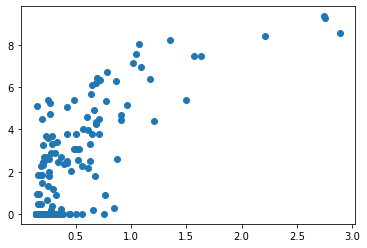

In [20]:
plt.scatter(centrality_df.logUsage, centrality_df.logImportance)

In [21]:
def pearson_corr(z1, z2):
    x1 = np.array(z1)
    x2=np.array(z2)
    x1_mean = np.mean(x1)
    x2_mean = np.mean(x1)

    x1_centered = x1 - x1_mean
    x2_centered = x2 - x2_mean
    return np.dot(x1_centered,x2_centered)/(np.linalg.norm(x1_centered)*np.linalg.norm(x2_centered))

pearson_corr(centrality_df.logUsage, centrality_df.logImportance)

0.7056706141157869

## Path Finding and Route Analysis

In [23]:
gds.run_cypher('''
    MATCH(n0) WHERE NOT n0:Airport
    MATCH(n1) WHERE NOT n1:Airport
    MATCH(n0)-[r]->(n1)
    WITH n0, n1,
        avg(r.effectiveMinutes) AS averageEffectiveMinutes,
        avg(r.plannedMinutes) AS averagePlannedMinutes
    MERGE(n0)-[s:SUPPLIES]->(n1)
    ON CREATE SET s.averageEffectiveMinutes = averageEffectiveMinutes,
        s.averagePlannedMinutes = averagePlannedMinutes
    RETURN count(s)
''')

,count(s)
0,1921


In [24]:
CHECKPOINT_NODE_LABELS = ['EntryPoint', 'DepartureWarehouse', 'DeparturePoint', 'ArrivalWarehouse', 'Destination']
g, _ = gds.graph.project('proj', CHECKPOINT_NODE_LABELS,
                         {'SUPPLIES':{'properties':['averageEffectiveMinutes','averagePlannedMinutes']}})

In [27]:
RELS_WITH_COST = ['CHECK_IN', 'DEPART', 'ACCEPT', 'DELIVER']
MATCH_RELS_WITH_COST_PATTERN = ':' + '|'.join(RELS_WITH_COST)
def get_airport_ids(row):
    return list( dict.fromkeys([n.get('airportId') for n in row.path.nodes]))


def calculate_shortest_paths(entry_id, destination_id, cost_metric, number_of_paths=5):
    source_id = gds.find_node_id(['EntryPoint'], {'airportId': entry_id})
    target_id = gds.find_node_id(['Destination'], {'airportId': destination_id})
    return gds.shortestPath.yens.stream(g, sourceNode=source_id, targetNode=target_id, k=number_of_paths,
                                        relationshipWeightProperty=cost_metric)

def get_shortest_routes(entry_id, destination_id, cost_metric, number_of_paths=5):
    paths_df = calculate_shortest_paths(entry_id, destination_id, cost_metric, number_of_paths)
    paths_df['airportPath'] = paths_df.apply(get_airport_ids, axis=1)
    return paths_df[['totalCost', 'airportPath']]


In [28]:
# Shortest Path - find the shortest path between two airports based on average effective times
airport_id_1 = 614
airport_id_2 = 485
get_shortest_routes(airport_id_1, airport_id_2, 'averageEffectiveMinutes', 7)

,totalCost,airportPath
0,2975.345532,"[614, 815, 485]"
1,3500.969698,"[614, 128, 485]"
2,3833.019250,"[614, 783, 815, 485]"
3,3857.002226,"[614, 815, 610, 485]"
4,3896.912144,"[614, 815, 134, 485]"
5,3898.427955,"[614, 128, 134, 485]"
6,3969.096071,"[614, 815, 281, 485]"
